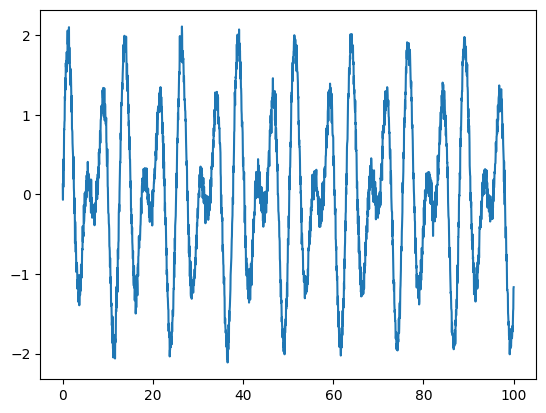

In [4]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim


# ====== Generating Dataset ====== #
num_data = 2400
t = np.linspace(0.0, 100.0, num_data)
y = np.sin(t) + np.sin(1.5*t) #+ np.sin(0.4*t)
e = np.random.normal(0, 0.1, num_data)
y = y + e


seq_len = 10
X = []
y_true = []
for i in range(len(t)-seq_len):
    X.append(y[i:i+seq_len])
    y_true.append(y[i+seq_len])
    
X = np.array(X)
y_true = np.array(y_true)

X = np.swapaxes(X,0,1)
X = np.expand_dims(X, axis=2)

plt.plot(t, y)
     

In [5]:
X

array([[[ 0.12661514],
        [-0.06699108],
        [ 0.31089242],
        ...,
        [-1.75739948],
        [-1.6899395 ],
        [-1.77519392]],

       [[-0.06699108],
        [ 0.31089242],
        [ 0.09294701],
        ...,
        [-1.6899395 ],
        [-1.77519392],
        [-1.80537613]],

       [[ 0.31089242],
        [ 0.09294701],
        [ 0.44350908],
        ...,
        [-1.77519392],
        [-1.80537613],
        [-1.76967652]],

       ...,

       [[ 0.81957019],
        [ 0.81110471],
        [ 0.90836122],
        ...,
        [-1.7007448 ],
        [-1.53427212],
        [-1.46542139]],

       [[ 0.81110471],
        [ 0.90836122],
        [ 0.93100839],
        ...,
        [-1.53427212],
        [-1.46542139],
        [-1.43595144]],

       [[ 0.90836122],
        [ 0.93100839],
        [ 1.22998667],
        ...,
        [-1.46542139],
        [-1.43595144],
        [-1.18372128]]])

In [6]:
X.shape # seq length, batch size, dimension

(10, 2390, 1)

In [7]:
for x in X:
    print(x.shape)
    break

(2390, 1)


In [8]:
y_true

array([ 0.93100839,  1.22998667,  1.19297631, ..., -1.43595144,
       -1.18372128, -1.16497525])

In [9]:
y_true.shape

(2390,)

In [10]:
import torch
import torch.nn as nn

In [32]:
class RNN(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, batch_size) -> None:
        super(RNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.fc_dim1 = 512
        self.fc_dim2 = 256
        self.batch_size = batch_size

        self.u = nn.Linear(self.input_dim, self.hid_dim, bias=False)
        self.w = nn.Linear(self.hid_dim, self.hid_dim, bias=False)
        self.v1 = nn.Linear(self.hid_dim, self.fc_dim1, bias=False)
        self.v2 = nn.Linear(self.fc_dim1, self.fc_dim2, bias=False)
        self.v3 = nn.Linear(self.fc_dim2, self.output_dim, bias=False)
        self.act = nn.Tanh()

        self.hidden = self.init_hidden() 

    def init_hidden(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        return torch.zeros(batch_size, self.hid_dim)

    def forward(self, x):
        h = self.act(self.u(x) + self.w(self.hidden))
        v = self.v1(h)
        v = self.v2(v)
        y = self.v3(v)
        return y, h
        

In [33]:
import torch.optim as optim

model = RNN(1, 1, 256, 2390)
optimizer = optim.Adam(model.parameters(), lr=0.0025)
loss_fn = nn.MSELoss()

In [34]:
# Training
epoch = 2000
pred_arr = []
for i in range(epoch):
    model.train()
    model.zero_grad()
    optimizer.zero_grad()
    
    model.hidden = model.init_hidden()
    
    for x in X:
        x = torch.Tensor(x).float()
        y_true = torch.Tensor(y_true).float()

        y_pred, hidden = model(x)
        model.hidden = hidden
        if i+1 == epoch:
            pred_arr.append(y_pred)
            

    loss = loss_fn(y_pred.view(-1), y_true.view(-1))
    loss.backward()
    optimizer.step()
    # print(loss.item())
    if i % 100 == 0:
        print(loss.item())

1.1900854110717773
0.020510492846369743
0.018852481618523598
0.01783735863864422
0.017591649666428566
0.015977101400494576
0.01483906339854002
0.015768546611070633
0.014367630705237389
0.0142112011089921
0.01434111688286066
0.014064379036426544
0.01406763307750225
0.01434933952987194
0.01567220874130726
0.01374672632664442
0.013831783086061478
0.013611599802970886
0.013461899012327194
0.013535491190850735


In [35]:
test_X = np.expand_dims(X[:, 0, :], 1)
test_X.shape

(10, 1, 1)

In [36]:
test_X

array([[[ 0.12661514]],

       [[-0.06699108]],

       [[ 0.31089242]],

       [[ 0.09294701]],

       [[ 0.44350908]],

       [[ 0.31185104]],

       [[ 0.45666291]],

       [[ 0.81957019]],

       [[ 0.81110471]],

       [[ 0.90836122]]])

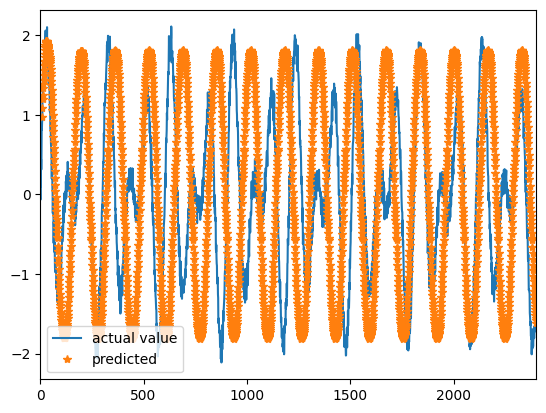

In [37]:
list_y_pred = []

model.eval()
with torch.no_grad():
    model.hidden = model.init_hidden(batch_size=1)

    for x in test_X:
        x = torch.Tensor(x).float()
        y_pred, hidden = model(x)
        model.hidden = hidden
    list_y_pred.append(y_pred.view(-1).item())
    
    temp_X = list()
    temp_X += list(np.squeeze(test_X))[1:]
    temp_X.append(y_pred.view(-1).item())
    for i in range(2389):
        model.hidden = model.init_hidden(batch_size=1)
        
        temp2_X = torch.unsqueeze(torch.unsqueeze(torch.Tensor(temp_X), 1), 1)
        
        for x in temp2_X:
            y_pred, hidden = model(x)
            model.hidden = hidden
        list_y_pred.append(y_pred.view(-1).item())
        
        temp_X.append(y_pred.view(-1).item())
        temp_X.pop(0)

plt.plot(y, label='actual value')
plt.plot(list(range(10, 2400)), list_y_pred, '*', label='predicted')
plt.xlim(0, 2400)
plt.legend()
     

----
* pytorch rnn module

In [151]:
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"

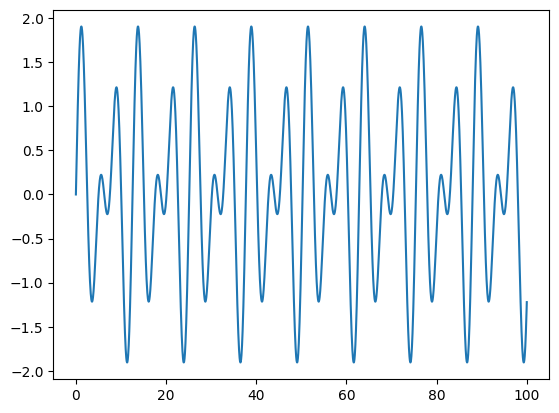

In [152]:
%matplotlib inline
# ====== Generating Dataset ====== #
num_data = 2400
t = torch.linspace(0.0, 100.0, num_data)
y = torch.sin(t) + np.sin(1.5*t) 
seq_len = 10

def input_data(seq,ws):
    out = []
    L = len(seq)
    
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    
    return out

train_set = input_data(y, seq_len)

plt.plot(t, y)
     

In [153]:
train_set[:10]

[(tensor([0.0000, 0.1042, 0.2080, 0.3112, 0.4135, 0.5145, 0.6139, 0.7115, 0.8069,
          0.8999]),
  tensor([0.9902])),
 (tensor([0.1042, 0.2080, 0.3112, 0.4135, 0.5145, 0.6139, 0.7115, 0.8069, 0.8999,
          0.9902]),
  tensor([1.0775])),
 (tensor([0.2080, 0.3112, 0.4135, 0.5145, 0.6139, 0.7115, 0.8069, 0.8999, 0.9902,
          1.0775]),
  tensor([1.1615])),
 (tensor([0.3112, 0.4135, 0.5145, 0.6139, 0.7115, 0.8069, 0.8999, 0.9902, 1.0775,
          1.1615]),
  tensor([1.2420])),
 (tensor([0.4135, 0.5145, 0.6139, 0.7115, 0.8069, 0.8999, 0.9902, 1.0775, 1.1615,
          1.2420]),
  tensor([1.3188])),
 (tensor([0.5145, 0.6139, 0.7115, 0.8069, 0.8999, 0.9902, 1.0775, 1.1615, 1.2420,
          1.3188]),
  tensor([1.3916])),
 (tensor([0.6139, 0.7115, 0.8069, 0.8999, 0.9902, 1.0775, 1.1615, 1.2420, 1.3188,
          1.3916]),
  tensor([1.4603])),
 (tensor([0.7115, 0.8069, 0.8999, 0.9902, 1.0775, 1.1615, 1.2420, 1.3188, 1.3916,
          1.4603]),
  tensor([1.5246])),
 (tensor([0.8069

In [154]:
class RNN2(nn.Module):
    def __init__(self,input_size = 1, hidden_size = 256, out_size = 1):
        super().__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size,out_size)
        self.hidden = torch.zeros(1,1, hidden_size)
    
    def forward(self,seq):
        rnn_out, self.hidden = self.rnn(seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(rnn_out.view(len(seq),-1))
        return pred[-1]

In [155]:
torch.manual_seed(42)
model = RNN2()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= .0015)
model.to(device)

RNN2(
  (rnn): RNN(1, 256)
  (linear): Linear(in_features=256, out_features=1, bias=True)
)

In [156]:
epochs = 10
y_pred_list = []
for i in range(epochs):
    
    for X_train, y_train in train_set:
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        optimizer.zero_grad()
        model.hidden = torch.zeros(1,1,model.hidden_size).to(device)
        
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        loss.backward()
        optimizer.step()
        if i == 9:
            y_pred_list.append(y_pred.view(-1).item())
        
    print(f"Epoch {i} Loss: {loss.item()}")

Epoch 0 Loss: 0.00018523549078963697
Epoch 1 Loss: 8.551261271350086e-05
Epoch 2 Loss: 0.0001383283524774015
Epoch 3 Loss: 0.0001829742395784706
Epoch 4 Loss: 0.00020186271285638213
Epoch 5 Loss: 0.000201920309336856
Epoch 6 Loss: 0.00020695866260211915
Epoch 7 Loss: 0.00020631776715163141
Epoch 8 Loss: 0.0002077826502500102
Epoch 9 Loss: 0.00020628694619517773


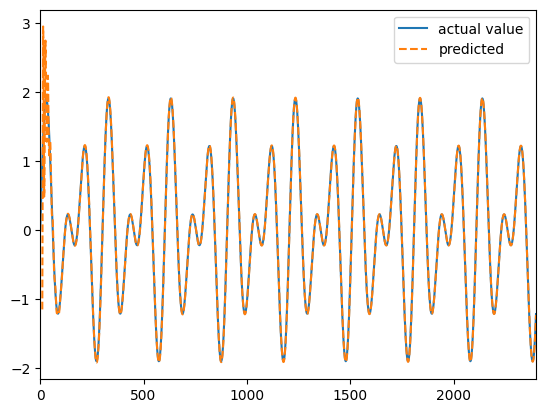

In [158]:
plt.plot(y, label='actual value')
plt.plot(list(range(10, 2400)), y_pred_list, '--', label='predicted')
plt.xlim(0, 2400)
plt.legend()